# PyTorch CNN model

In this notebook, we build a convolutional neural network (CNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module.

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import (
    load_datasets, prepare_splits, create_dataloaders
)
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)
from image_classification_tools.pytorch.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [ ]:
batch_size = 64
learning_rate = 1e-3
epochs = 150
print_every = 25 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load and preprocess CIFAR-10 data

### 1.1. Load datasets and create DataLoaders

In [ ]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Define transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Step 1: Load datasets
train_dataset, test_dataset = load_datasets(
    data_source=datasets.CIFAR10,
    train_transform=transform,
    eval_transform=transform,
    download=True,
    root=data_dir
)

# Step 2: Prepare splits with GPU preloading for small dataset
train_dataset, val_dataset, test_dataset = prepare_splits(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_val_split=0.8,
    preload_to_memory=True,
    device=device
)

# Step 3: Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=batch_size
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 625
Validation batches: 157
Test batches: 157


### 1.2. Visualize sample images

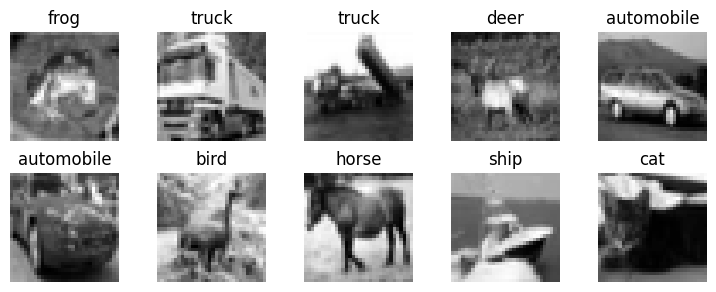

In [4]:
# Get a sample dataset for visualization
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

## 2. Build CNN classifier with nn.Sequential

We build a convolutional neural network using `nn.Sequential`. The CNN uses convolutional layers to extract spatial features from the 32x32x1 grayscale images before classification.

### 2.1. Define model architecture

In [5]:
# Input: 1 x 32 x 32 (grayscale)
model = nn.Sequential(

    # Conv block 1: 1 -> 32 channels, 32x32 -> 16x16
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    
    # Classifier
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)

).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): AdaptiveAvgPool2d(output_size=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=32, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 15210


### 2.2. Define loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [ ]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    lazy_loading=False,
    epochs=epochs,
    print_every=print_every
)

print()

Epoch 1/150 - loss: 1.8840 - accuracy: 29.80% - val_loss: 1.6862 - val_accuracy: 38.41%
Epoch 10/150 - loss: 1.4321 - accuracy: 48.62% - val_loss: 1.3377 - val_accuracy: 51.87%
Epoch 20/150 - loss: 1.3402 - accuracy: 52.55% - val_loss: 1.2766 - val_accuracy: 54.12%
Epoch 30/150 - loss: 1.2852 - accuracy: 54.57% - val_loss: 1.2856 - val_accuracy: 53.76%
Epoch 40/150 - loss: 1.2555 - accuracy: 55.92% - val_loss: 1.2750 - val_accuracy: 54.32%
Epoch 50/150 - loss: 1.2167 - accuracy: 57.24% - val_loss: 1.1815 - val_accuracy: 56.64%
Epoch 60/150 - loss: 1.2003 - accuracy: 57.79% - val_loss: 1.1515 - val_accuracy: 59.26%
Epoch 70/150 - loss: 1.1708 - accuracy: 58.92% - val_loss: 1.1434 - val_accuracy: 60.30%
Epoch 80/150 - loss: 1.1513 - accuracy: 59.47% - val_loss: 1.1080 - val_accuracy: 60.57%
Epoch 90/150 - loss: 1.1361 - accuracy: 60.00% - val_loss: 1.1219 - val_accuracy: 60.95%
Epoch 100/150 - loss: 1.1217 - accuracy: 60.53% - val_loss: 1.0939 - val_accuracy: 60.16%
Epoch 110/150 - loss:

### 2.5. Learning curves

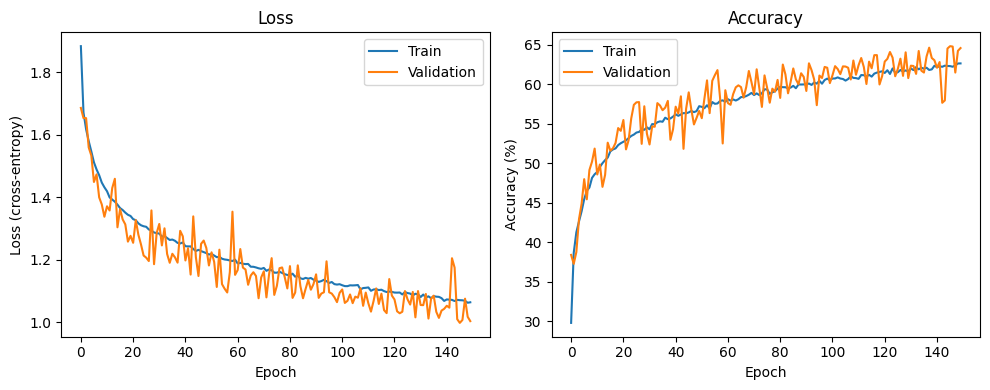

In [8]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [9]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 63.55%


### 3.2. Per-class accuracy

In [10]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 70.90%
automobile  : 83.70%
bird        : 46.20%
cat         : 32.80%
deer        : 57.00%
dog         : 68.80%
frog        : 66.90%
horse       : 66.20%
ship        : 69.40%
truck       : 73.60%


### 3.4. Confusion matrix

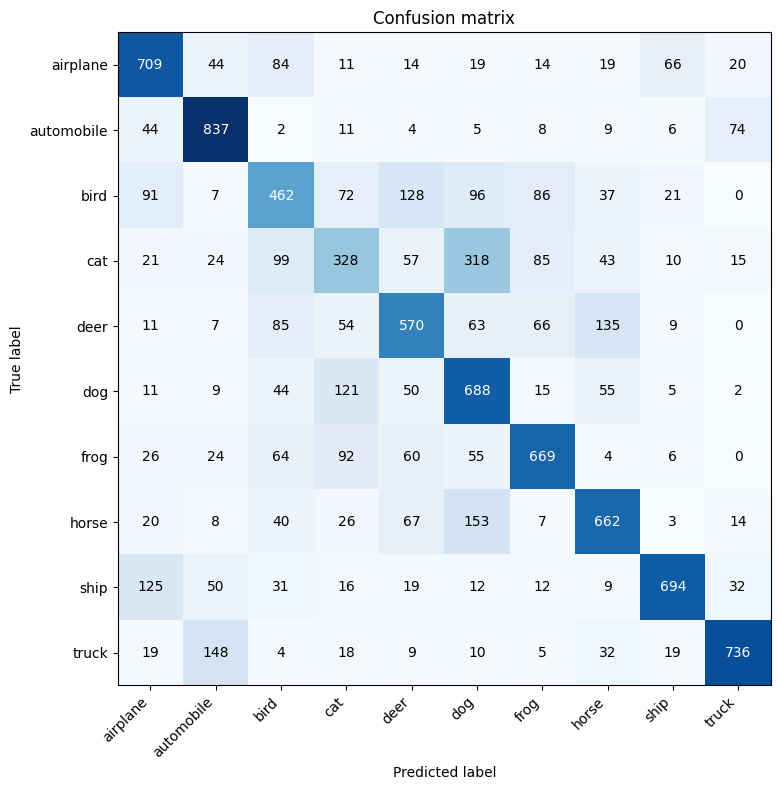

In [11]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.5. Predicted class probability distributions

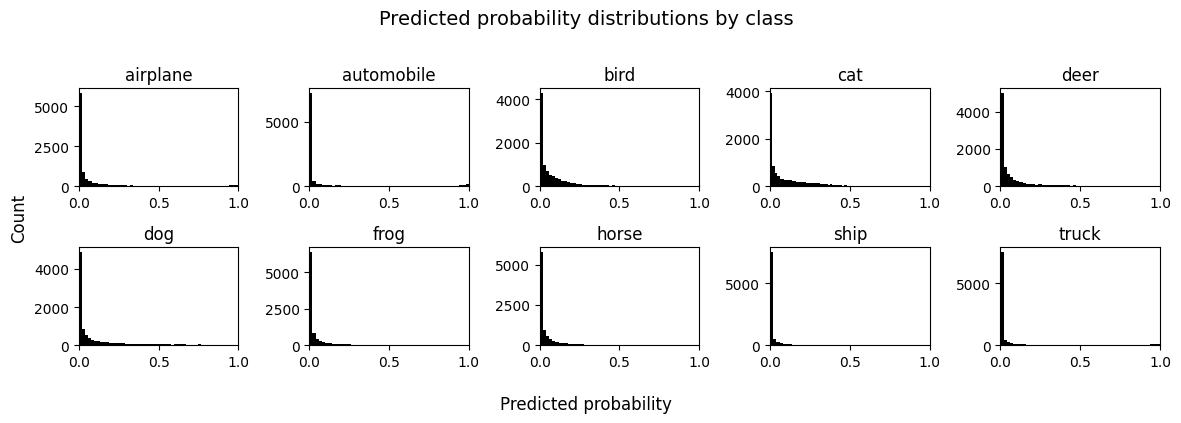

In [12]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.6. Evaluation curves

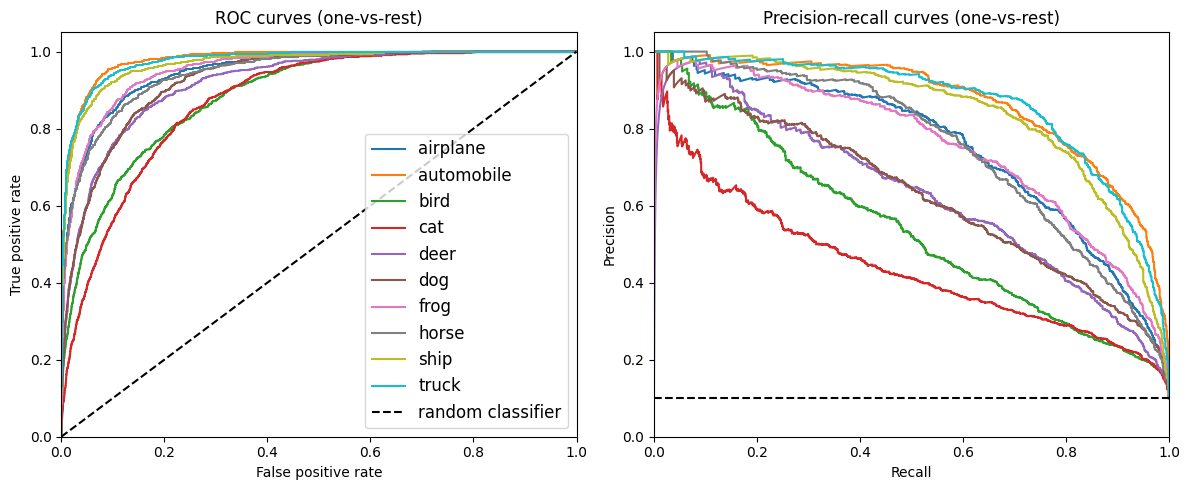

In [13]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [14]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/cnn.pth
Test accuracy: 63.55%
